In [1]:
from common.common_imports import *
from common.util import *
from data.dataloader import *
from transformer import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# PARAMS
batch_size = 4
test_size = 20
row_len = 12
days_pred_list = [5]
num_epochs = 2
max_src_window = 2000

# model
num_heads=3
num_encoder_layers=4
num_decoder_layers=4
dropout_p=0.1

# optim
lr = 0.1
max_grad_norm = 10000

In [4]:
# DATALOADER
train_loader, test_loader = create_splits(
    batch_size=batch_size,
    test_size=test_size,
    reset_progress=True
)

In [5]:
# MODEL
model = stonks_transformer_model(
    d_model=row_len,
    nhead=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dropout=dropout_p,
    device=device
)

/home/kanesweet/anaconda3/envs/stonksEnv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because num_head is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
# for batch,lengths in tqdm(train_loader):
#     validate_batch(batch, lengths, max_src_window, days_pred=5)

  0%|          | 0/2308 [00:00<?, ?it/s]

215: loss is nan
2237: loss is nan


<function matplotlib.pyplot.show(close=None, block=None)>

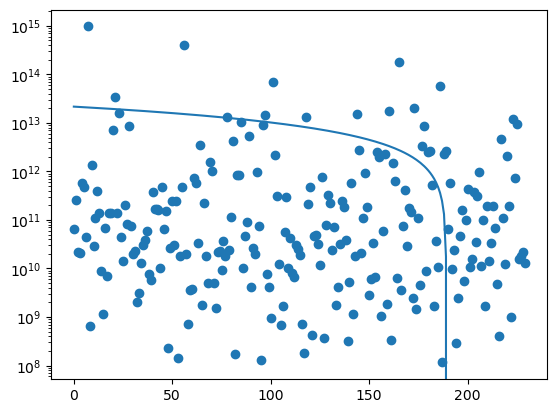

In [7]:
y = train_stonks_transformer(
    model=model,
    learning_rate=lr,
    max_grad_norm=max_grad_norm,
    days_pred_list=days_pred_list,
    train_loader=train_loader,
    num_epochs=num_epochs*20,
    max_src_window=max_src_window,
    device=device
)

<function matplotlib.pyplot.show(close=None, block=None)>

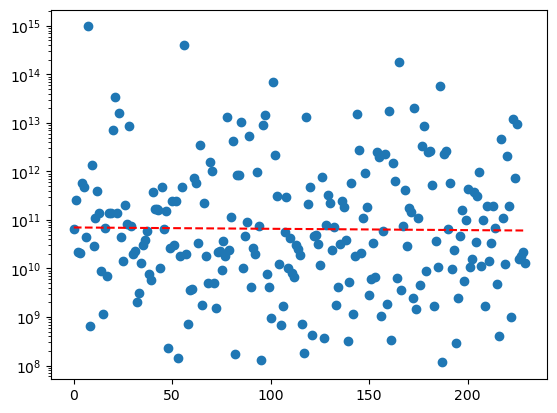

In [9]:
x = np.arange(len(y))
plt.scatter(x, y)
z = np.polyfit(x, np.log10(y), 1)
p = np.poly1d(z)
plt.plot(x, 10**p(x), "r--")
plt.yscale("log")
plt.show

In [14]:
print(p)

 
-0.0002738 x + 10.85
